# Getting started

*Run this example in* [colab](https://colab.research.google.com/drive/16tEQBo8GzqehT8fRoiuTA7uHF7zyIRZ4)!

To use MICE, first you need to define a function with the gradient that you want to approximate.
For example, here we have a two-dimensional quadratic function,

$$
f(\boldsymbol{\xi}, \theta) = \frac{1}{2} \boldsymbol{\xi} \cdot \boldsymbol{H}(\theta) \boldsymbol{\xi}
- \boldsymbol{b} \cdot \boldsymbol{\xi}
$$

where

$$
\begin{aligned}
    \boldsymbol{\xi} \quad & \textrm{ is a vector containing the optimization variables, } \\
    \theta \quad & \textrm{ is a random variable, } \\
    f(\boldsymbol{\xi}, \theta) \quad & \textrm{ is a function whose expectation wrt } \theta \textrm{ is to be minimized, } \\
    \boldsymbol{H}(\theta) \quad & \textrm{ is the Hessian matrix, } \\
    \boldsymbol{b} \quad & \textrm{is a vector of the same dimension as } \boldsymbol{\xi}.
    \end{aligned}
$$

Here, we have a Hessian that is a convex combination of the identity matrix and of an arbitrary matrix:

$$
\boldsymbol{H}(\theta) =
\boldsymbol{I}_2(1 -\theta) +
\begin{bmatrix}
\kappa & \kappa-1 \\
        \kappa-1 & \kappa
\end{bmatrix}
\theta,
$$

noting that $\theta$ is a random variable such that $\theta \sim \mathcal{U}[0, 1]$
and $\kappa$ is the desired conditioning number of the expected value of the Hessian.
Also, $\boldsymbol{b}$ is a 2-dimensional vector with ones.

To use the stochastic gradient method, we need the gradient of $f$ wrt $\boldsymbol{\xi}$:

$$
\nabla_{\boldsymbol{\xi}} f(\boldsymbol{\xi}, \theta) = \boldsymbol{H}(\theta) \boldsymbol{\xi} - \boldsymbol{b}.
$$

To use MICE to estimate $\nabla_{\boldsymbol{\xi}} f$, we need to import the MICE class and NumPy to assist us in
defining our problem.

In [ ]:
!pip install -U mice
import matplotlib.pyplot as plt
import numpy as np
from mice import MICE, plot_mice

Then, we need to define $\nabla_{\boldsymbol{\xi}} f$ as a function of $\boldsymbol{\xi}$ and an array representing a sample of $\theta$.

In [2]:
kappa = 100
H_aux = np.array([[kappa, kappa-1], [kappa-1, kappa]])
b = np.ones(2)


def dobjf(x, thetas):
    gradients = []
    for theta in thetas:
        H = np.eye(2) * (1 - theta) + H_aux * theta
        gradients.append(H @ x.T - b)
    return np.vstack(gradients)

As for $\theta$, we can pass to MICE either a sampler function that takes the desired sample size as input and returns the sample
or a list/array containing the data.
Here, we will define a function that returns the uniform sample between 0 and 1,

In [3]:
def sampler(n):
    return np.random.uniform(0, 1, int(n))

Now, let's create an instance of MICE to solve this optimization problem with tolerance to statistical error of $\epsilon=0.7$,
maximum cost of $10,000$ evaluations of $\nabla_{\boldsymbol{\xi}} f$, and a minimum batch size of $5$.

In [5]:
df = MICE(dobjf,
          sampler=sampler,
          eps=.7,
          max_cost=1e4,
          min_batch=5,
          stop_crit_norm=1)

To perform optimization, we need to set a starting point and a step size. 
Here, we know both the $L$-smoothness and the $\mu$-convexity parameters of the problem, thus we can set the step size optimally.

In [6]:
x = np.array([20., 50.])
L = kappa
mu = 1
step_size = 2 / (L + mu) / (1 + df.eps ** 2)

and, finally, we iterate until MICE's cost is reached, in which case df.terminate returns True,

In [7]:
while True:
    grad = df.evaluate(x)
    if df.terminate:
        break
    x = x - step_size * grad

Finally, let's plot the convergence of the norm of MICE's gradient estimates from the log DataFrame using the built-in plot_mice function.

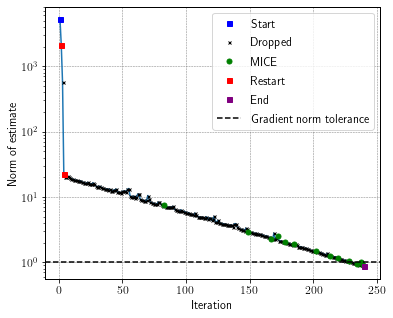

In [8]:
log = df.get_log()
fig, ax = plt.subplots(figsize=(6, 5))
ax = plot_mice(log, ax, 'iteration', 'grad_norm', style='semilogy')
ax.axhline(df.stop_crit_norm, ls='--', c='k', label='Gradient norm tolerance')
ax.set_xlabel('Iteration')
ax.set_ylabel('Norm of estimate')
ax.legend()